In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

sa_up_layers = 1.8
dist = 1

In [3]:
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_vid
from pytorch3d.renderer import FoVPerspectiveCameras

n_frames = 5
angles = torch.linspace(-20, 20, n_frames)
angles = [0, 45, 135, 180, 225, 315]

R, T = turntable_extrinsics(dists=1, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=60)
frame_meshes = mesh.extend(len(frame_cams))

depths = render_depth_map(frame_meshes, frame_cams)

display_vid(pil_frames_to_clip(depths))

In [4]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(
    TexturingPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers
from text3d2video.utilities.camera_placement import cam_view_prompt

sa_up_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)

layers_factor = 1.0
max_layer_index = int(len(sa_up_layers) * layers_factor)

module_paths = sa_up_layers[:max_layer_index]

cfg = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Stormtrooper"

prompt_views = [cam_view_prompt(a) for a in angles]
prompts = [f'{prompt}, {view} view' for view in prompt_views]
prompts

['Stormtrooper, front view',
 'Stormtrooper, front view',
 'Stormtrooper, back view',
 'Stormtrooper, back view',
 'Stormtrooper, back view',
 'Stormtrooper, front view']

In [28]:
noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

video_frames = pipe(
    prompts,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    conf=cfg,
    generator=generator,
)

100%|██████████| 15/15 [00:48<00:00,  3.25s/it]


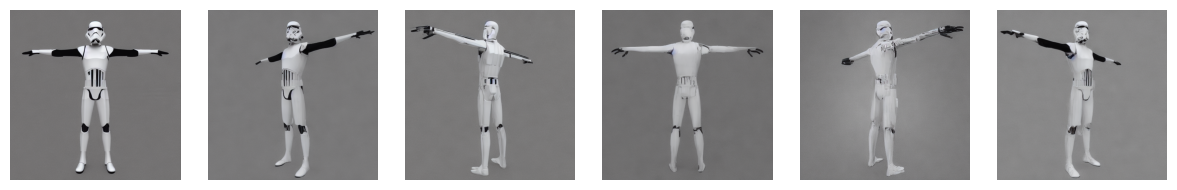

In [25]:
from text3d2video.ipython_utils import display_ims

display_ims(video_frames)

In [26]:
display_vid(pil_frames_to_clip(video_frames))